In [393]:
import pandas as pd
import re

In [394]:
df = pd.read_csv('matches_data_testrun.csv', encoding='ISO-8859-1', low_memory=False)

In [395]:
def extract_percentage(value):
    if isinstance(value, str):
        match = re.search(r'\((\d+)%\)', value)
        if match:
            return float(match.group(1)) / 100  # Convert percentage to decimal
    return value  # If no percentage found, return the original value

In [396]:
team_dict = {}

# Iterate over the DataFrame and add both home and away teams and their IDs to the dictionary
for index, row in df.iterrows():
    team_dict[row['homeId']] = row['homeTeam']
    team_dict[row['awayId']] = row['awayTeam']



In [397]:
team_columns = df[['homeTeam', 'awayTeam']]
df = df.drop(columns=['eventId','date','time','homeTeam','awayTeam'], axis=1)



In [398]:
percentage_columns = ['homeballPossession', 'awayballPossession', 'homeduelWonPercent', 'awayduelWonPercent', 
                      'homegroundDuelsPercentage', 'awaygroundDuelsPercentage', 'homeaerialDuelsPercentage', 'awayaerialDuelsPercentage',
                      'homewonTacklePercent', 'awaywonTacklePercent', 'homedribblesPercentage', 'awaydribblesPercentage']


# Step 2: Remove the '%' sign and convert to decimals
for col in percentage_columns:
    df[col] = df[col].apply(extract_percentage)
    df[col] = df[col].astype(str).str.replace('%', '').astype(float) / 100

    

In [399]:
df['homePoints'] = df.apply(lambda row: 3 if row['homeScore'] > row['awayScore'] else (1 if row['homeScore'] == row['awayScore'] else 0), axis=1)
df['awayPoints'] = df.apply(lambda row: 3 if row['awayScore'] > row['homeScore'] else (1 if row['homeScore'] == row['awayScore'] else 0), axis=1)

In [400]:
df['homeGD'] = df['homeScore'] - df['awayScore']
df['awayGD'] = df['awayScore'] - df['homeScore']

In [401]:
columns = df.columns

In [402]:
home_columns = [col for col in columns if 
                col.startswith('home')]
away_columns = [col for col in columns if col.startswith('away')]

In [403]:
# Rename the columns to make them uniform for aggregation
df_home = df[home_columns].rename(columns=lambda x: x.replace('home', 'team'))
df_away = df[away_columns].rename(columns=lambda x: x.replace('away', 'team'))

In [404]:
df_combined = pd.concat([df_home.rename(columns={'homeId': 'teamId'}), 
                         df_away.rename(columns={'awayId': 'teamId'})])

In [405]:
df = df.fillna(0)


In [406]:
def calculate_rolling_feature(df, feature_name, home_feature, away_feature, window=5):
    # Prepare home DataFrame
    home_df = df[['index', 'homeId', home_feature]]
    home_df = home_df.rename(columns={
        'homeId': 'teamId',
        home_feature: 'featureValue'
    })
    
    # Prepare away DataFrame
    away_df = df[['index', 'awayId', away_feature]]
    away_df = away_df.rename(columns={
        'awayId': 'teamId',
        away_feature: 'featureValue'
    })
    
    # Concatenate
    feature_df = pd.concat([home_df, away_df], ignore_index=True)
    
    # Calculate rolling average excluding current match
    feature_df['shiftedFeature'] = feature_df.groupby('teamId')['featureValue'].shift()
    
    feature_df['rollingAvg'] = feature_df.groupby('teamId')['shiftedFeature'].rolling(window=window, min_periods=1).mean().reset_index(level=0, drop=True)
    
    # Merge back to original DataFrame for home teams
    home_features = feature_df[feature_df['teamId'].isin(df['homeId'])][['index', 'teamId', 'rollingAvg']]
    home_features = home_features.rename(columns={'rollingAvg': f'homeRollingAvg{feature_name}'})
    
    df = df.merge(
        home_features,
        left_on=['index', 'homeId'],
        right_on=['index', 'teamId'],
        how='left'
    ).drop('teamId', axis=1)
    
    # Merge back for away teams
    away_features = feature_df[feature_df['teamId'].isin(df['awayId'])][['index', 'teamId', 'rollingAvg']]
    away_features = away_features.rename(columns={'rollingAvg': f'awayRollingAvg{feature_name}'})
    
    df = df.merge(
        away_features,
        left_on=['index', 'awayId'],
        right_on=['index', 'teamId'],
        how='left'
    ).drop('teamId', axis=1)
    
    return df


In [407]:
# Assuming the DataFrame index reflects the chronological order
df.reset_index(inplace=True)


In [408]:
# Calculate rolling averages for 'ballPossession' and replace NaNs with 0
df = calculate_rolling_feature(df, 'ballPossession', 'homeballPossession', 'awayballPossession', window=5)
df = calculate_rolling_feature(df, 'Score', 'homeScore', 'awayScore', window=5)
df = calculate_rolling_feature(df, 'Points', 'homePoints', 'awayPoints', window=5)
df = calculate_rolling_feature(df, 'GD', 'homeGD', 'awayGD', window=5)
# Calculate rolling averages for 'totalShotsOnGoal' and replace NaNs with 0
df = calculate_rolling_feature(df, 'totalShotsOnGoal', 'hometotalShotsOnGoal', 'awaytotalShotsOnGoal', window=5)
df = calculate_rolling_feature(df, 'expectedGoals', 'homeexpectedGoals', 'awayexpectedGoals', window=5)


In [409]:
df.fillna(0)

,index,homeId,awayId,homeElo,awayElo,homeAggElo,awayAggElo,homeScore,awayScore,FTR,...,homeRollingAvgScore,awayRollingAvgScore,homeRollingAvgPoints,awayRollingAvgPoints,homeRollingAvgGD,awayRollingAvgGD,homeRollingAvgtotalShotsOnGoal,awayRollingAvgtotalShotsOnGoal,homeRollingAvgexpectedGoals,awayRollingAvgexpectedGoals
0,0,2513,2505,1500.0,1500.0,1300.000000,1300.000000,2,0,1,...,0.0,1.0,0.0,0.8,0.0,-1.2,0.000,5.664,0.000,0.594
1,1,22010,7080,1500.0,1500.0,1300.000000,1300.000000,1,3,2,...,0.0,0.8,0.0,0.6,0.0,-1.4,0.000,6.000,0.000,0.520
2,2,2512,21825,1500.0,1500.0,1300.000000,1300.000000,1,0,1,...,0.0,1.0,0.0,0.6,0.0,-0.6,0.000,4.800,0.000,0.652
3,3,2508,2504,1500.0,1500.0,1300.000000,1300.000000,1,0,1,...,0.0,2.6,0.0,1.8,0.0,0.8,0.000,6.578,0.000,1.300
4,4,22007,5133,1500.0,1500.0,1300.000000,1300.000000,0,0,3,...,0.0,1.6,0.0,1.8,0.0,0.4,0.000,5.332,0.000,0.530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33604,33604,2841,4488,1500.0,1500.0,1300.032760,1429.319012,0,3,2,...,0.0,0.6,0.0,0.6,0.0,-2.4,0.000,7.000,0.000,0.848
33605,33605,2866,2835,1500.0,1500.0,1300.000000,1305.472465,3,4,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000
33606,33606,243027,2819,1500.0,1500.0,1300.000000,1631.029387,1,6,2,...,0.0,1.4,0.0,2.0,0.0,0.2,0.000,6.552,0.000,0.638
33607,33607,2504,2506,1500.0,1500.0,1768.517862,1610.384550,0,1,2,...,2.6,1.6,1.8,1.0,0.2,0.2,7.400,7.200,1.332,0.810


In [410]:
df.to_csv('tttt.csv',index=False)

In [411]:
df_combined = df_combined.dropna()

In [412]:
df_combined.to_csv('testing.csv',index=False)

In [413]:
df_combined = df_combined.sort_values(by=['teamId'], ascending=[True])


In [414]:
recent_elo_stats = df_combined.drop_duplicates(subset='teamId', keep='first',)

In [415]:
recent_elo_stats = recent_elo_stats[['teamId', 'teamElo', 'teamAggElo']]

In [416]:
# Ensure 'teamId' is of a hashable type (e.g., int or string)
# Create the dictionary
elo_dict = recent_elo_stats.set_index('teamId')['teamElo'].to_dict()

In [417]:
import pickle
# Specify the filename
filename = 'elo_dict.pkl'

# 1. Pickle the dictionary
with open(filename, 'wb') as file:
    pickle.dump(elo_dict, file)



In [418]:
# Identify object columns
object_cols = df_combined.select_dtypes(include=['object']).columns

# Convert object columns to numeric, coercing errors
df_combined[object_cols] = df_combined[object_cols].apply(pd.to_numeric)


In [419]:
team_avg_stats = df_combined.groupby('teamId').mean().reset_index()
team_avg_stats

,teamId,teamElo,teamAggElo,teamScore,teamballPossession,teamtotalShotsOnGoal,teamgoalkeeperSaves,teamcornerKicks,teamfouls,teampasses,...,teamdiveSaves,teamtouchesInOppBox,teampenaltySaves,teampunches,teamerrorsLeadToGoal,teamexpectedGoals,teamgoalsPrevented,teamerrorsLeadToShot,teamPoints,teamGD
0,1,1346.346823,1449.550239,1.174224,0.501718,6.868735,1.536993,2.694511,11.293556,192.150358,...,0.002387,0.758950,0.0,0.002387,0.000000,0.075203,-0.016539,0.000000,1.229117,-0.233890
1,2,1456.650739,1379.034365,1.100000,0.443000,4.300000,2.000000,1.700000,13.000000,179.200000,...,0.200000,15.600000,0.0,0.300000,0.000000,0.403000,-0.215000,0.100000,0.800000,-1.000000
2,3,1663.733914,1622.183860,1.221636,0.500369,6.606860,1.525066,2.543536,10.472296,215.976253,...,0.013193,0.445910,0.0,0.000000,0.000000,0.135330,-0.005356,0.000000,1.393140,-0.050132
3,4,1377.521210,1288.907455,0.829268,0.510488,6.707317,1.707317,2.829268,0.000000,196.926829,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.780488,-0.756098
4,5,1223.724171,1304.850852,0.818182,0.441591,5.878788,1.772727,2.500000,9.537879,170.166667,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.772727,-0.901515
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400,337612,1588.768597,1612.343905,1.283133,0.462229,6.361446,1.825301,2.445783,12.072289,194.632530,...,0.024096,3.048193,0.0,0.006024,0.000000,0.286928,-0.006988,0.012048,1.373494,0.144578
401,377973,1445.717440,1526.863769,1.369565,0.520072,6.688406,2.130435,2.797101,11.427536,209.260870,...,0.036232,3.891304,0.0,0.014493,0.000000,0.363913,0.069783,0.007246,1.224638,-0.166667
402,404108,1449.872628,1477.766048,1.313725,0.506373,6.000000,1.637255,2.568627,12.186275,215.568627,...,0.088235,5.254902,0.0,0.009804,0.009804,0.424902,0.114608,0.019608,1.303922,-0.117647
403,407803,1512.398814,1502.339605,1.637681,0.448261,7.333333,1.898551,2.304348,14.391304,178.173913,...,0.144928,8.246377,0.0,0.086957,0.000000,0.669275,0.166667,0.000000,1.347826,0.043478


In [420]:
# Merge the most recent Elo values into the averaged stats dataframe
team_avg_stats = team_avg_stats.merge(recent_elo_stats[['teamId', 'teamElo', 'teamAggElo']], 
                                      on='teamId', 
                                      how='left')


In [421]:
# Replace the average Elo with the most recent Elo
team_avg_stats['teamElo'] = team_avg_stats['teamElo_y']
team_avg_stats['teamAggElo'] = team_avg_stats['teamAggElo_y']


In [422]:
team_avg_stats.drop(columns=['teamElo_x', 'teamAggElo_x', 'teamElo_y', 'teamAggElo_y','teamElo','teamAggElo'], inplace=True)

In [423]:
team_avg_stats

,teamId,teamScore,teamballPossession,teamtotalShotsOnGoal,teamgoalkeeperSaves,teamcornerKicks,teamfouls,teampasses,teamfreeKicks,teamyellowCards,...,teamdiveSaves,teamtouchesInOppBox,teampenaltySaves,teampunches,teamerrorsLeadToGoal,teamexpectedGoals,teamgoalsPrevented,teamerrorsLeadToShot,teamPoints,teamGD
0,1,1.174224,0.501718,6.868735,1.536993,2.694511,11.293556,192.150358,5.677804,1.343675,...,0.002387,0.758950,0.0,0.002387,0.000000,0.075203,-0.016539,0.000000,1.229117,-0.233890
1,2,1.100000,0.443000,4.300000,2.000000,1.700000,13.000000,179.200000,6.900000,1.800000,...,0.200000,15.600000,0.0,0.300000,0.000000,0.403000,-0.215000,0.100000,0.800000,-1.000000
2,3,1.221636,0.500369,6.606860,1.525066,2.543536,10.472296,215.976253,5.189974,1.242744,...,0.013193,0.445910,0.0,0.000000,0.000000,0.135330,-0.005356,0.000000,1.393140,-0.050132
3,4,0.829268,0.510488,6.707317,1.707317,2.829268,0.000000,196.926829,6.731707,1.414634,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.780488,-0.756098
4,5,0.818182,0.441591,5.878788,1.772727,2.500000,9.537879,170.166667,5.893939,1.265152,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.772727,-0.901515
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400,337612,1.283133,0.462229,6.361446,1.825301,2.445783,12.072289,194.632530,5.620482,1.192771,...,0.024096,3.048193,0.0,0.006024,0.000000,0.286928,-0.006988,0.012048,1.373494,0.144578
401,377973,1.369565,0.520072,6.688406,2.130435,2.797101,11.427536,209.260870,5.398551,1.318841,...,0.036232,3.891304,0.0,0.014493,0.000000,0.363913,0.069783,0.007246,1.224638,-0.166667
402,404108,1.313725,0.506373,6.000000,1.637255,2.568627,12.186275,215.568627,5.627451,1.607843,...,0.088235,5.254902,0.0,0.009804,0.009804,0.424902,0.114608,0.019608,1.303922,-0.117647
403,407803,1.637681,0.448261,7.333333,1.898551,2.304348,14.391304,178.173913,5.579710,1.652174,...,0.144928,8.246377,0.0,0.086957,0.000000,0.669275,0.166667,0.000000,1.347826,0.043478


In [424]:
team_avg_stats.columns

Index(['teamId', 'teamScore', 'teamballPossession', 'teamtotalShotsOnGoal',
       'teamgoalkeeperSaves', 'teamcornerKicks', 'teamfouls', 'teampasses',
       'teamfreeKicks', 'teamyellowCards', 'teamshotsOnGoal',
       'teamhitWoodwork', 'teamshotsOffGoal', 'teamblockedScoringAttempt',
       'teamtotalShotsInsideBox', 'teamtotalShotsOutsideBox',
       'teamaccurateThroughBall', 'teamoffsides', 'teamaccuratePasses',
       'teamthrowIns', 'teamduelWonPercent', 'teamgroundDuelsPercentage',
       'teamaerialDuelsPercentage', 'teamgoalKicks', 'teambigChanceCreated',
       'teamtotalTackle', 'teambigChanceMissed', 'teamfouledFinalThird',
       'teamfinalThirdEntries', 'teamaccurateLongBalls', 'teamaccurateCross',
       'teamdispossessed', 'teamdribblesPercentage', 'teamwonTacklePercent',
       'teaminterceptionWon', 'teamballRecovery', 'teamtotalClearance',
       'teamredCards', 'teambigChanceScored', 'teamfinalThirdPhaseStatistic',
       'teamhighClaims', 'teamdiveSaves', 'teamt

In [425]:
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
from sklearn.manifold import LocallyLinearEmbedding
import scipy

class ArchetypalAnalysis(BaseEstimator, TransformerMixin):

    def __init__(self, n_archetypes=None, tmax=20, iterations=10):
        '''
        Implements archetypal analysis 
            Archetypal Analysis as an Autoencoder (Bauckhage et al. 2015)

        Parameters
        ----------

        n_archetypes : the number of archetype
        
        tmax : the number of iterations of the derivative update

        iterations : the number of iterations of the overall algorithm


        Notes
        ---------

        The matrices have the following dimensions (following the above paper)
        [X] - m x n
        [Z] - m x k
        [B] - n x k
        [A] - k x n
        [e_A] - k x 1
        [e_B] - n x 1

        Source: https://miller-blog.com/archetypal-analysis/

        '''
        self.n_archetypes = n_archetypes
        self.tmax = tmax
        self.iterations = iterations

        N = self.n_archetypes
        x, y = np.zeros(N), np.zeros(N)
        x[1:] = np.cumsum(np.cos(np.arange(0, N - 1) * 2 * np.pi / N))
        y[1:] = np.cumsum(np.sin(np.arange(0, N - 1) * 2 * np.pi / N))
        self.map2D = np.vstack((x, y))

    def fit(self, X, y=None):
        """Fit the model with X using Archetypal Analysis
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            Training data, where n_samples is the number of samples
            and n_features is the number of features.
        y : Ignored
        Returns
        -------
        self : object
            Returns the instance itself.

        Source: https://miller-blog.com/archetypal-analysis/
        """
        self._fit(X)
        return self

    def _fit(self, X):
        k = self.n_archetypes
        m, n = X.shape

        B = np.eye(n, k)
        Z = X @ B

        for i in range(self.iterations):
            A = self._computeA(X, Z, self.tmax)
            B = self._computeB(X, A, self.tmax)
            Z = X @ B
            print('RSS = {}'.format(self._rss(X, A, Z)))

        self.Z_ = Z
        self.A_ = A

    def _computeA(self, X, Z, tmax):
        ''' 
        Algorithm 1 of Bauckhage et al. 2015
        Source: https://miller-blog.com/archetypal-analysis/
        '''
        m, n = X.shape
        k = self.n_archetypes

        A = np.zeros((k, n))
        A[0, :] = 1.0
        for t in range(tmax):
            # brackets are important to get reasonable sizes
            # [G] ~  k x n
            G = 2.0 * ((Z.T @ Z) @ A - Z.T @ X)
            # Get the argument mins along each column
            argmins = np.argmin(G, axis=0)
            e = np.zeros(G.shape)
            e[argmins, range(n)] = 1.0
            A += 2.0 / (t + 2.0) * (e - A)
        return A

    def _computeB(self, X, A, tmax):
        ''' 
        Algorithm 2 of Bauckhage et al. 2015
        Source: https://miller-blog.com/archetypal-analysis/
        '''
        k, n = A.shape
        B = np.zeros((n, k))
        B[0, :] = 1.0
        for t in range(tmax):
            # brackets are important to get reasonable sizes
            t1 = X.T @ (X @ B) @ (A @ A.T)
            t2 = X.T @ (X @ A.T)
            G = 2.0 * (t1 - t2)
            argmins = np.argmin(G, axis=0)
            e = np.zeros(G.shape)
            e[argmins, range(k)] = 1.0
            B += 2.0 / (t + 2.0) * (e - B)
        return B

    def archetypes(self):
        '''
        Source: https://miller-blog.com/archetypal-analysis/
        '''
        return self.Z_

    def transform(self, X):
        '''
        Source: https://miller-blog.com/archetypal-analysis/
        '''
        return self._computeA(X, self.Z_, self.tmax)

    def _rss(self, X, A, Z):
        '''
        Source: https://miller-blog.com/archetypal-analysis/
        '''
        return np.linalg.norm(X - Z @ A)


def archetypal_plot(ax, data, dp, epsilon=0.2):
    '''
    Source: Dr. Luke Bovard
    '''
    ax.scatter(data[0, :], data[1, :], alpha=0.6, linewidths=10)
    ax.scatter(dp[0, :], dp[1, :], c='orange')

    for i in range(dp.shape[1]):
        if dp[0, i] < 0.5:
            eps_x = -epsilon
        else:
            eps_x = epsilon
        if dp[1, i] < np.max(dp[1, :]) / 2.0:
            eps_y = -epsilon
        else:
            eps_y = epsilon
        ax.text(dp[0, i] + eps_x, dp[1, i] + eps_y, "{}".format(i + 1))
    return ax

In [426]:
team_avg_stats.set_index('teamId', inplace=True)
X_transposed = team_avg_stats.transpose()

In [427]:

from sklearn.preprocessing import StandardScaler
archetypal=ArchetypalAnalysis(n_archetypes=5,iterations=50,tmax=430)
scaler = StandardScaler()
X = scaler.fit_transform(X_transposed)

a = archetypal.fit(X)

RSS = 4.757916162889651
RSS = 3.9845161922397883
RSS = 3.734206083579728
RSS = 3.6333914986631903
RSS = 3.5867473101419756
RSS = 3.56087365633224
RSS = 3.539105087332261
RSS = 3.5138692471871873
RSS = 3.477884568832279
RSS = 3.4646851764792412
RSS = 3.458929060220691
RSS = 3.4545931841747715
RSS = 3.4520450539556675
RSS = 3.450320697838381
RSS = 3.449281068396004
RSS = 3.448023887688815
RSS = 3.446977162936809
RSS = 3.4457776042124633
RSS = 3.44471566520251
RSS = 3.4441948716777357
RSS = 3.442779115311008
RSS = 3.442201516155941
RSS = 3.4413136791953076
RSS = 3.4405970207953884
RSS = 3.4401292396644645
RSS = 3.4395176078718794
RSS = 3.4389374177851684
RSS = 3.438646448868503
RSS = 3.4382082097106252
RSS = 3.437867425570143
RSS = 3.437485706703234
RSS = 3.4371834641251713
RSS = 3.4366886818934423
RSS = 3.436499453098362
RSS = 3.436097431447678
RSS = 3.4358472614677025
RSS = 3.435587450590147
RSS = 3.4354903709563174
RSS = 3.4354741371024686
RSS = 3.4350245611881256
RSS = 3.4349773186820

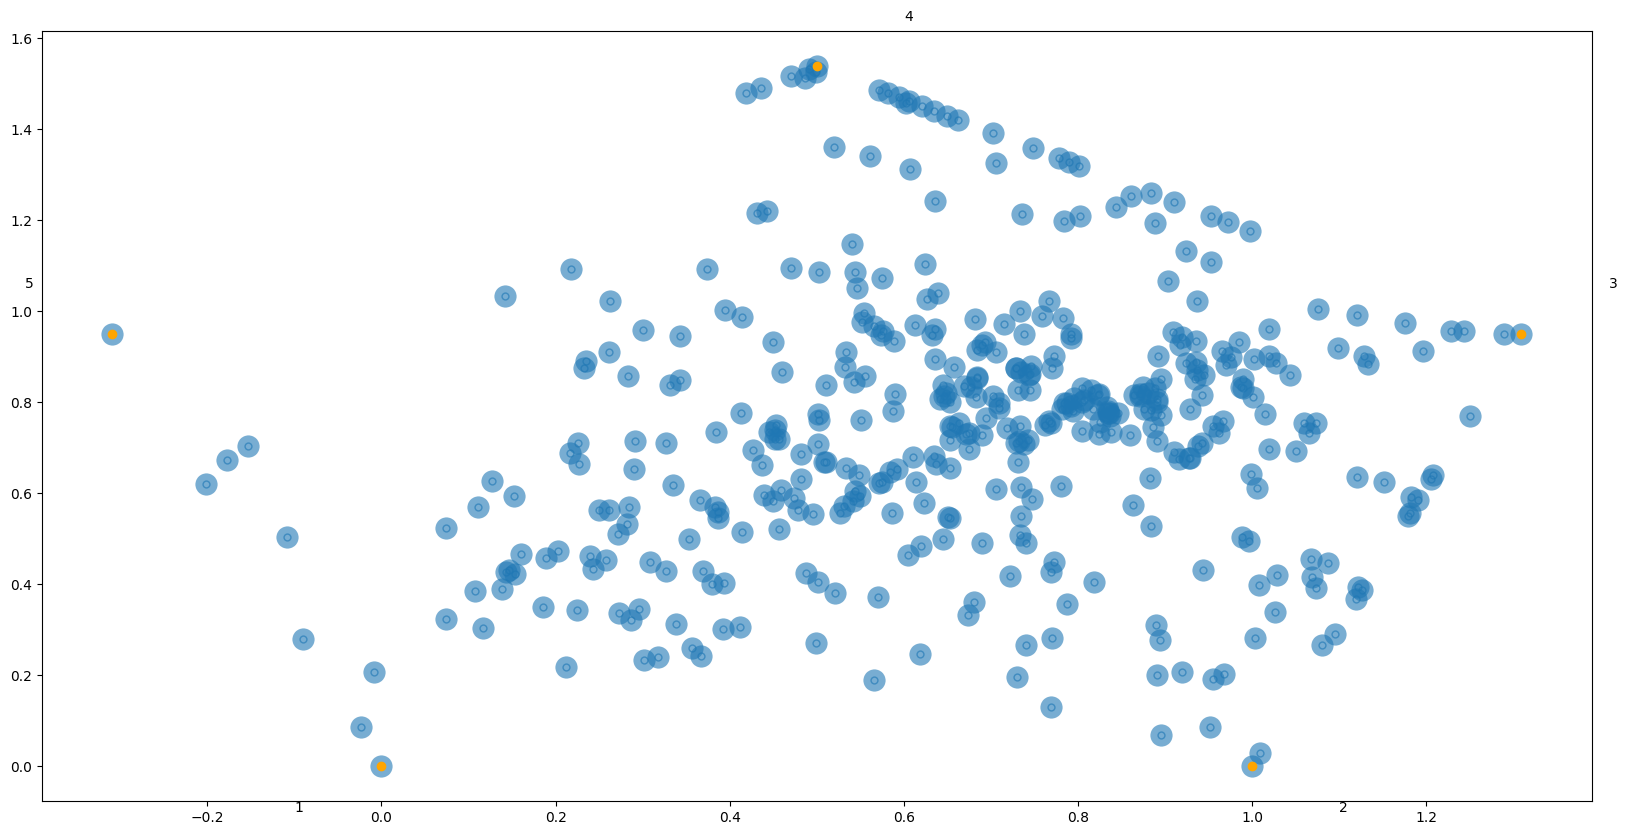

In [428]:
import matplotlib.pyplot as plt

A=archetypal.transform(X)
dp=archetypal.map2D
dat=dp @ A
f, ax = plt.subplots(figsize=(20, 10))
ax=archetypal_plot(ax,dat,dp,epsilon=.1)
ax.set_aspect('auto')
plt.show()

    


In [429]:
# Transpose back to get shape (405, 5)
A = A.T  # Shape: (405, 5)

A.shape
# Create a DataFrame with 'teamId' as index
A_df = pd.DataFrame(
    A,
    index=team_avg_stats.index,  # teamId as index
    columns=[f'Archetype_{i+1}' for i in range(5)]
)

print("Transformed DataFrame shape:", A_df.shape)
print(A_df.head())


Transformed DataFrame shape: (405, 5)
        Archetype_1  Archetype_2  Archetype_3  Archetype_4  Archetype_5
teamId                                                                 
1          0.035547     0.084908     0.336891     0.239109     0.303545
2          0.000000     0.574435     0.232256     0.000022     0.193288
3          0.158506     0.073857     0.427648     0.246889     0.093099
4          0.000000     0.000000     0.088912     0.911088     0.000000
5          0.007209     0.149992     0.051152     0.496207     0.295441


In [430]:
# Add 'teamName' as a new column by mapping 'teamId' using team_dict
A_df['teamName'] = A_df.index.map(team_dict)

print("Transformed DataFrame with teamName:")
print(A_df.head())


Transformed DataFrame with teamName:
        Archetype_1  Archetype_2  Archetype_3  Archetype_4  Archetype_5  \
teamId                                                                    
1          0.035547     0.084908     0.336891     0.239109     0.303545   
2          0.000000     0.574435     0.232256     0.000022     0.193288   
3          0.158506     0.073857     0.427648     0.246889     0.093099   
4          0.000000     0.000000     0.088912     0.911088     0.000000   
5          0.007209     0.149992     0.051152     0.496207     0.295441   

                   teamName  
teamId                       
1       Queens Park Rangers  
2                Portsmouth  
3             Wolverhampton  
4        Milton Keynes Dons  
5          Bolton Wanderers  


In [431]:
A

array([[3.55474019e-02, 8.49080019e-02, 3.36890951e-01, 2.39108617e-01,
        3.03545028e-01],
       [0.00000000e+00, 5.74434792e-01, 2.32255976e-01, 2.15831220e-05,
        1.93287649e-01],
       [1.58506448e-01, 7.38574435e-02, 4.27647979e-01, 2.46889333e-01,
        9.30987967e-02],
       ...,
       [0.00000000e+00, 2.65623482e-01, 6.05946150e-01, 0.00000000e+00,
        1.28430367e-01],
       [5.13786219e-02, 6.20924837e-01, 2.28802676e-01, 0.00000000e+00,
        9.88938650e-02],
       [9.85269519e-02, 6.88825339e-01, 2.12604543e-01, 0.00000000e+00,
        4.31662440e-05]])

In [432]:
import pandas as pd

# Number of clusters
num_clusters = A.shape[1]

# Create column names for the probabilities
probability_columns = [f'cluster_confidence_{i}' for i in range(1, num_clusters + 1)]

# Convert the probabilities array to a DataFrame
probabilities_df = pd.DataFrame(A, columns=probability_columns)
    

In [443]:
team_avg_stats.reset_index()

,teamId,teamScore,teamballPossession,teamtotalShotsOnGoal,teamgoalkeeperSaves,teamcornerKicks,teamfouls,teampasses,teamfreeKicks,teamyellowCards,...,teamdiveSaves,teamtouchesInOppBox,teampenaltySaves,teampunches,teamerrorsLeadToGoal,teamexpectedGoals,teamgoalsPrevented,teamerrorsLeadToShot,teamPoints,teamGD
0,1,1.174224,0.501718,6.868735,1.536993,2.694511,11.293556,192.150358,5.677804,1.343675,...,0.002387,0.758950,0.0,0.002387,0.000000,0.075203,-0.016539,0.000000,1.229117,-0.233890
1,2,1.100000,0.443000,4.300000,2.000000,1.700000,13.000000,179.200000,6.900000,1.800000,...,0.200000,15.600000,0.0,0.300000,0.000000,0.403000,-0.215000,0.100000,0.800000,-1.000000
2,3,1.221636,0.500369,6.606860,1.525066,2.543536,10.472296,215.976253,5.189974,1.242744,...,0.013193,0.445910,0.0,0.000000,0.000000,0.135330,-0.005356,0.000000,1.393140,-0.050132
3,4,0.829268,0.510488,6.707317,1.707317,2.829268,0.000000,196.926829,6.731707,1.414634,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.780488,-0.756098
4,5,0.818182,0.441591,5.878788,1.772727,2.500000,9.537879,170.166667,5.893939,1.265152,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.772727,-0.901515
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400,337612,1.283133,0.462229,6.361446,1.825301,2.445783,12.072289,194.632530,5.620482,1.192771,...,0.024096,3.048193,0.0,0.006024,0.000000,0.286928,-0.006988,0.012048,1.373494,0.144578
401,377973,1.369565,0.520072,6.688406,2.130435,2.797101,11.427536,209.260870,5.398551,1.318841,...,0.036232,3.891304,0.0,0.014493,0.000000,0.363913,0.069783,0.007246,1.224638,-0.166667
402,404108,1.313725,0.506373,6.000000,1.637255,2.568627,12.186275,215.568627,5.627451,1.607843,...,0.088235,5.254902,0.0,0.009804,0.009804,0.424902,0.114608,0.019608,1.303922,-0.117647
403,407803,1.637681,0.448261,7.333333,1.898551,2.304348,14.391304,178.173913,5.579710,1.652174,...,0.144928,8.246377,0.0,0.086957,0.000000,0.669275,0.166667,0.000000,1.347826,0.043478


In [445]:
# Ensure that indices in team_avg_stats and probabilities_df match
probabilities_df.index = team_avg_stats.index

# Concatenate the probabilities DataFrame with team_avg_stats
team_avg_stats_with_confidences = pd.concat([team_avg_stats, probabilities_df], axis=1)

team_avg_stats_with_confidences.reset_index()

,teamId,teamScore,teamballPossession,teamtotalShotsOnGoal,teamgoalkeeperSaves,teamcornerKicks,teamfouls,teampasses,teamfreeKicks,teamyellowCards,...,teamexpectedGoals,teamgoalsPrevented,teamerrorsLeadToShot,teamPoints,teamGD,cluster_confidence_1,cluster_confidence_2,cluster_confidence_3,cluster_confidence_4,cluster_confidence_5
0,1,1.174224,0.501718,6.868735,1.536993,2.694511,11.293556,192.150358,5.677804,1.343675,...,0.075203,-0.016539,0.000000,1.229117,-0.233890,0.035547,0.084908,0.336891,0.239109,0.303545
1,2,1.100000,0.443000,4.300000,2.000000,1.700000,13.000000,179.200000,6.900000,1.800000,...,0.403000,-0.215000,0.100000,0.800000,-1.000000,0.000000,0.574435,0.232256,0.000022,0.193288
2,3,1.221636,0.500369,6.606860,1.525066,2.543536,10.472296,215.976253,5.189974,1.242744,...,0.135330,-0.005356,0.000000,1.393140,-0.050132,0.158506,0.073857,0.427648,0.246889,0.093099
3,4,0.829268,0.510488,6.707317,1.707317,2.829268,0.000000,196.926829,6.731707,1.414634,...,0.000000,0.000000,0.000000,0.780488,-0.756098,0.000000,0.000000,0.088912,0.911088,0.000000
4,5,0.818182,0.441591,5.878788,1.772727,2.500000,9.537879,170.166667,5.893939,1.265152,...,0.000000,0.000000,0.000000,0.772727,-0.901515,0.007209,0.149992,0.051152,0.496207,0.295441
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400,337612,1.283133,0.462229,6.361446,1.825301,2.445783,12.072289,194.632530,5.620482,1.192771,...,0.286928,-0.006988,0.012048,1.373494,0.144578,0.230324,0.152118,0.485350,0.000000,0.132207
401,377973,1.369565,0.520072,6.688406,2.130435,2.797101,11.427536,209.260870,5.398551,1.318841,...,0.363913,0.069783,0.007246,1.224638,-0.166667,0.136136,0.137905,0.615972,0.000000,0.109988
402,404108,1.313725,0.506373,6.000000,1.637255,2.568627,12.186275,215.568627,5.627451,1.607843,...,0.424902,0.114608,0.019608,1.303922,-0.117647,0.000000,0.265623,0.605946,0.000000,0.128430
403,407803,1.637681,0.448261,7.333333,1.898551,2.304348,14.391304,178.173913,5.579710,1.652174,...,0.669275,0.166667,0.000000,1.347826,0.043478,0.051379,0.620925,0.228803,0.000000,0.098894


In [ ]:

# # Assuming team_avg_stats and probabilities_df are already defined with teamID as index

# # Concatenate the DataFrames
# team_avg_stats_with_confidences = pd.concat([team_avg_stats, probabilities_df], axis=1)

# # Reset the index to turn 'teamID' into a column
# team_avg_stats_with_confidences = team_avg_stats_with_confidences.reset_index()

# # Rename 'index' to 'teamID' if necessary
# team_avg_stats_with_confidences.rename(columns={'index': 'teamId'}, inplace=True)

# # Add 'teamName' as a new column
# team_avg_stats_with_confidences['teamName'] = team_avg_stats_with_confidences['teamId'].map(team_dict)

# # Reorder columns to have 'teamID' and 'teamName' first
# cols = ['teamId', 'teamName'] + [col for col in team_avg_stats_with_confidences.columns if col not in ['teamId', 'teamName']]
# team_avg_stats_with_confidences = team_avg_stats_with_confidences[cols]

# # Display the final DataFrame
# print(team_avg_stats_with_confidences.head())
# team_avg_stats_with_confidences

# # Optionally, save to a CSV file
# # team_avg_stats_with_confidences.to_csv('team_stats_with_confidences.csv', index=False)


   teamId             teamName  teamScore  teamballPossession  \
0       1  Queens Park Rangers   1.174224            0.501718   
1       2           Portsmouth   1.100000            0.443000   
2       3        Wolverhampton   1.221636            0.500369   
3       4   Milton Keynes Dons   0.829268            0.510488   
4       5     Bolton Wanderers   0.818182            0.441591   

   teamtotalShotsOnGoal  teamgoalkeeperSaves  teamcornerKicks  teamfouls  \
0              6.868735             1.536993         2.694511  11.293556   
1              4.300000             2.000000         1.700000  13.000000   
2              6.606860             1.525066         2.543536  10.472296   
3              6.707317             1.707317         2.829268   0.000000   
4              5.878788             1.772727         2.500000   9.537879   

   teampasses  teamfreeKicks  ...  teamexpectedGoals  teamgoalsPrevented  \
0  192.150358       5.677804  ...           0.075203           -0.016539   


,teamId,teamName,teamScore,teamballPossession,teamtotalShotsOnGoal,teamgoalkeeperSaves,teamcornerKicks,teamfouls,teampasses,teamfreeKicks,...,teamexpectedGoals,teamgoalsPrevented,teamerrorsLeadToShot,teamPoints,teamGD,cluster_confidence_1,cluster_confidence_2,cluster_confidence_3,cluster_confidence_4,cluster_confidence_5
0,1,Queens Park Rangers,1.174224,0.501718,6.868735,1.536993,2.694511,11.293556,192.150358,5.677804,...,0.075203,-0.016539,0.000000,1.229117,-0.233890,0.035547,0.084908,0.336891,0.239109,0.303545
1,2,Portsmouth,1.100000,0.443000,4.300000,2.000000,1.700000,13.000000,179.200000,6.900000,...,0.403000,-0.215000,0.100000,0.800000,-1.000000,0.000000,0.574435,0.232256,0.000022,0.193288
2,3,Wolverhampton,1.221636,0.500369,6.606860,1.525066,2.543536,10.472296,215.976253,5.189974,...,0.135330,-0.005356,0.000000,1.393140,-0.050132,0.158506,0.073857,0.427648,0.246889,0.093099
3,4,Milton Keynes Dons,0.829268,0.510488,6.707317,1.707317,2.829268,0.000000,196.926829,6.731707,...,0.000000,0.000000,0.000000,0.780488,-0.756098,0.000000,0.000000,0.088912,0.911088,0.000000
4,5,Bolton Wanderers,0.818182,0.441591,5.878788,1.772727,2.500000,9.537879,170.166667,5.893939,...,0.000000,0.000000,0.000000,0.772727,-0.901515,0.007209,0.149992,0.051152,0.496207,0.295441
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400,337612,Nashville SC,1.283133,0.462229,6.361446,1.825301,2.445783,12.072289,194.632530,5.620482,...,0.286928,-0.006988,0.012048,1.373494,0.144578,0.230324,0.152118,0.485350,0.000000,0.132207
401,377973,Austin FC,1.369565,0.520072,6.688406,2.130435,2.797101,11.427536,209.260870,5.398551,...,0.363913,0.069783,0.007246,1.224638,-0.166667,0.136136,0.137905,0.615972,0.000000,0.109988
402,404108,Charlotte FC,1.313725,0.506373,6.000000,1.637255,2.568627,12.186275,215.568627,5.627451,...,0.424902,0.114608,0.019608,1.303922,-0.117647,0.000000,0.265623,0.605946,0.000000,0.128430
403,407803,St.Louis City,1.637681,0.448261,7.333333,1.898551,2.304348,14.391304,178.173913,5.579710,...,0.669275,0.166667,0.000000,1.347826,0.043478,0.051379,0.620925,0.228803,0.000000,0.098894


In [446]:
team_avg_stats_with_confidences.to_csv('team_statistics.csv', index = False)

In [66]:
cluster_means = team_avg_stats.groupby('cluster').mean()


In [376]:
df = pd.read_csv('matches_data_testrun.csv', encoding='ISO-8859-1',low_memory=False)

In [377]:
# team_clusters = team_avg_stats.set_index('teamId')['cluster']

In [383]:
probabilities_df

,cluster_confidence_1,cluster_confidence_2,cluster_confidence_3,cluster_confidence_4,cluster_confidence_5
teamId,,,,,
1,0.035547,0.084908,0.336891,0.239109,0.303545
2,0.000000,0.574435,0.232256,0.000022,0.193288
3,0.158506,0.073857,0.427648,0.246889,0.093099
4,0.000000,0.000000,0.088912,0.911088,0.000000
5,0.007209,0.149992,0.051152,0.496207,0.295441
...,...,...,...,...,...
337612,0.230324,0.152118,0.485350,0.000000,0.132207
377973,0.136136,0.137905,0.615972,0.000000,0.109988
404108,0.000000,0.265623,0.605946,0.000000,0.128430


In [452]:
match_df = pd.read_csv('matches_data_testrun.csv', encoding='ISO-8859-1',low_memory=False)
team_avg_stats_with_confidences = team_avg_stats_with_confidences.reset_index()

In [453]:
team_avg_stats_with_confidences = team_avg_stats_with_confidences[['teamId','cluster_confidence_1','cluster_confidence_2','cluster_confidence_3','cluster_confidence_4','cluster_confidence_5']]


In [454]:
# Merge match_df with team_avg_stats_with_confidences for home team
merged_df = match_df.merge(
    team_avg_stats_with_confidences,
    how='left',
    left_on='homeId',
    right_on='teamId'
)


In [455]:
# Identify confidence columns
confidence_cols = [col for col in team_avg_stats_with_confidences.columns if col != 'teamId']

# Create a mapping for renaming
home_confidence_cols = {col: f'home_{col}' for col in confidence_cols}

# Rename columns
merged_df.rename(columns=home_confidence_cols, inplace=True)


In [456]:
merged_df.drop(columns='teamId', inplace=True)


In [457]:
# Merge merged_df with team_avg_stats_with_confidences for away team
merged_df = merged_df.merge(
    team_avg_stats_with_confidences,
    how='left',
    left_on='awayId',
    right_on='teamId',
    suffixes=('', '_away')
)


In [458]:
# Create a mapping for renaming
away_confidence_cols = {f'{col}_away': f'away_{col}' for col in confidence_cols}

# Rename columns
merged_df.rename(columns=away_confidence_cols, inplace=True)


In [459]:
merged_df.drop(columns='teamId', inplace=True)


In [460]:
merged_df.to_csv('match_w_conf.csv', index=False)

In [461]:
df.to_csv('inspection.csv',index=False)


In [464]:
team_avg_stats_with_confidences

,teamId,cluster_confidence_1,cluster_confidence_2,cluster_confidence_3,cluster_confidence_4,cluster_confidence_5
0,1,0.035547,0.084908,0.336891,0.239109,0.303545
1,2,0.000000,0.574435,0.232256,0.000022,0.193288
2,3,0.158506,0.073857,0.427648,0.246889,0.093099
3,4,0.000000,0.000000,0.088912,0.911088,0.000000
4,5,0.007209,0.149992,0.051152,0.496207,0.295441
...,...,...,...,...,...,...
400,337612,0.230324,0.152118,0.485350,0.000000,0.132207
401,377973,0.136136,0.137905,0.615972,0.000000,0.109988
402,404108,0.000000,0.265623,0.605946,0.000000,0.128430
403,407803,0.051379,0.620925,0.228803,0.000000,0.098894


In [466]:

import pickle

team_clusters = team_avg_stats_with_confidences.set_index('teamId').T.to_dict()

print(team_clusters)
# Assume your dictionary is named 'my_dict'
# Save it to a file
with open('my_dict.pkl', 'wb') as f:
    pickle.dump(team_clusters, f)


{1: {'cluster_confidence_1': 0.0355474019316894, 'cluster_confidence_2': 0.08490800194248095, 'cluster_confidence_3': 0.33689095127610186, 'cluster_confidence_4': 0.2391086170614579, 'cluster_confidence_5': 0.30354502778826953}, 2: {'cluster_confidence_1': 0.0, 'cluster_confidence_2': 0.5744347919926619, 'cluster_confidence_3': 0.23225597582690324, 'cluster_confidence_4': 2.158312199859711e-05, 'cluster_confidence_5': 0.1932876490584364}, 3: {'cluster_confidence_1': 0.15850644795769703, 'cluster_confidence_2': 0.07385744347919936, 'cluster_confidence_3': 0.42764797928020276, 'cluster_confidence_4': 0.24688933254195197, 'cluster_confidence_5': 0.09309879674094854}, 4: {'cluster_confidence_1': 0.0, 'cluster_confidence_2': 0.0, 'cluster_confidence_3': 0.0889116710732207, 'cluster_confidence_4': 0.9110883289267788, 'cluster_confidence_5': 0.0}, 5: {'cluster_confidence_1': 0.007208762747531433, 'cluster_confidence_2': 0.14999190632925055, 'cluster_confidence_3': 0.05115199913667512, 'cluste

In [290]:
# Filter matches where Real Madrid is the home or away team
real_madrid_matches = merged_df[
    (df['homeId'] == 2829) |
    (df['awayId'] == 2829)
]

real_madrid_matches


,eventId,homeId,homeTeam,awayId,awayTeam,homeElo,awayElo,homeAggElo,awayAggElo,homeScore,...,home_cluster_confidence_1,home_cluster_confidence_2,home_cluster_confidence_3,home_cluster_confidence_4,home_cluster_confidence_5,cluster_confidence_1,cluster_confidence_2,cluster_confidence_3,cluster_confidence_4,cluster_confidence_5
323,6807351,2852,Sporting GijÃÂ³n,2829,Real Madrid,1500.000000,1500.000000,1300.000000,1300.000000,0,...,0.167993,0.123529,0.093504,0.482208,0.132766,0.211090,0.348957,0.117991,0.144396,0.177566
373,6807382,2829,Real Madrid,2816,Real Betis,1502.516774,1497.374874,1301.609566,1299.369095,5,...,0.211090,0.348957,0.117991,0.144396,0.177566,0.299906,0.312718,0.076861,0.108948,0.201568
460,6807388,2814,Espanyol,2829,Real Madrid,1492.219474,1534.324426,1300.859573,1316.895316,0,...,0.421844,0.168782,0.068735,0.117842,0.222797,0.211090,0.348957,0.117991,0.144396,0.177566
530,6874279,2829,Real Madrid,3313,Shakhtar Donetsk,1582.028534,1500.000000,1348.726232,1300.000000,4,...,0.211090,0.348957,0.117991,0.144396,0.177566,0.278265,0.217708,0.113278,0.172911,0.217838
610,6807404,2829,Real Madrid,33779,Granada,1606.953457,1463.163115,1357.327892,1298.143019,1,...,0.211090,0.348957,0.117991,0.144396,0.177566,0.360595,0.159646,0.078782,0.150537,0.250440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33258,12764304,1643,Lille,2829,Real Madrid,1842.647221,2402.947566,1704.337470,2165.119299,1,...,0.239878,0.437445,0.067296,0.091625,0.163755,0.211090,0.348957,0.117991,0.144396,0.177566
33333,12437813,2829,Real Madrid,2819,Villarreal,2379.825149,1834.728007,2273.336277,1690.839008,2,...,0.211090,0.348957,0.117991,0.144396,0.177566,0.285072,0.332797,0.079043,0.116572,0.186516
33412,12437842,2821,Celta Vigo,2829,Real Madrid,1559.719658,2386.878120,1655.127235,2248.343546,1,...,0.346925,0.251388,0.077785,0.121784,0.202119,0.211090,0.348957,0.117991,0.144396,0.177566
33428,12437842,2821,Celta Vigo,2829,Real Madrid,1555.800470,2390.797308,1652.960738,2252.643108,1,...,0.346925,0.251388,0.077785,0.121784,0.202119,0.211090,0.348957,0.117991,0.144396,0.177566


In [77]:
# Step 3: Display the relevant columns
columns_to_display = ['homeTeam', 'awayTeam', 'homeCluster', 'awayCluster']
print(real_madrid_matches[columns_to_display])

              homeTeam           awayTeam  homeCluster  awayCluster
323    Sporting GijÃ³n        Real Madrid          3.0          1.0
373        Real Madrid         Real Betis          1.0          1.0
460           Espanyol        Real Madrid          2.0          1.0
530        Real Madrid   Shakhtar Donetsk          1.0          2.0
610        Real Madrid            Granada          1.0          2.0
...                ...                ...          ...          ...
33258            Lille        Real Madrid          1.0          1.0
33333      Real Madrid         Villarreal          1.0          1.0
33412       Celta Vigo        Real Madrid          2.0          1.0
33428       Celta Vigo        Real Madrid          2.0          1.0
33489      Real Madrid  Borussia Dortmund          1.0          1.0

[461 rows x 4 columns]
